In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ProjectTweets Analysis") \
    .getOrCreate()

tweets_df = spark.read.csv("/destination/in/hdfs/ProjectTweets.csv", header=True, inferSchema=True)
tweets_df.show()


+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("tweets_analysis").getOrCreate()
tweets_df = spark.read.csv("/destination/in/hdfs/ProjectTweets.csv", header=False, inferSchema=True)


In [3]:
tweets_df = tweets_df.withColumnRenamed("_c0", "ID") \
                     .withColumnRenamed("_c1", "Timestamp") \
                     .withColumnRenamed("_c2", "Date") \
                     .withColumnRenamed("_c3", "Query") \
                     .withColumnRenamed("_c4", "User") \
                     .withColumnRenamed("_c5", "Text")


In [4]:
from pyspark.sql.functions import col

null_counts = tweets_df.select([col(c).isNull().cast("int").alias(c) for c in tweets_df.columns]).groupBy().sum().collect()[0]

for col_name, null_count in null_counts.asDict().items():
    print(f"{col_name}: {null_count}")


sum(ID): 0
sum(Timestamp): 0
sum(Date): 0
sum(Query): 0
sum(User): 0
sum(Text): 0


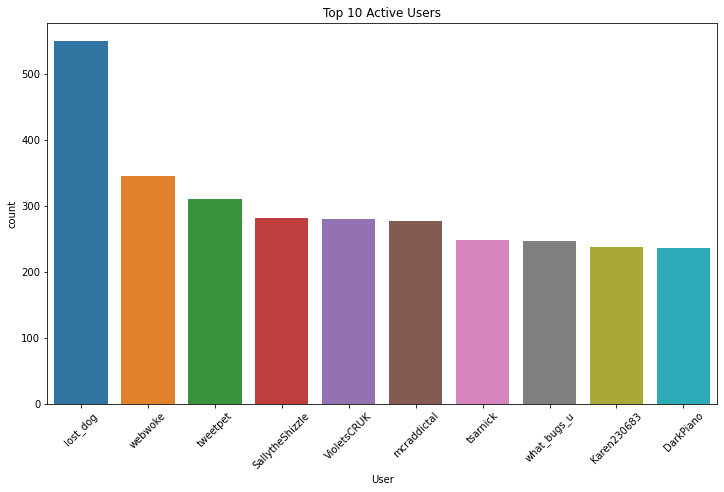

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Örneğin User sütunundaki en aktif kullanıcıları bulma ve görselleştirme
top_users = tweets_df.groupBy("User").count().orderBy(col("count").desc()).limit(10).toPandas()

plt.figure(figsize=(12,7))
sns.barplot(x="User", y="count", data=top_users)
plt.title("Top 10 Active Users")
plt.xticks(rotation=45)
plt.show()


In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("twitterAnalysis").getOrCreate()

# Veriyi okuma
tweets_df = spark.read.csv('/destination/in/hdfs/ProjectTweets.csv', inferSchema=True, header=False)

# Sütun isimlerini yeniden adlandırma
tweets_df = tweets_df.withColumnRenamed("_c0", "index") \
                     .withColumnRenamed("_c1", "tweet_id") \
                     .withColumnRenamed("_c2", "timestamp") \
                     .withColumnRenamed("_c3", "query") \
                     .withColumnRenamed("_c4", "user") \
                     .withColumnRenamed("_c5", "text")

tweets_df.show(5)


+-----+----------+--------------------+--------+---------------+--------------------+
|index|  tweet_id|           timestamp|   query|           user|                text|
+-----+----------+--------------------+--------+---------------+--------------------+
|    0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|    2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|    4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+-----+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [7]:
top_users = tweets_df.groupBy("user").count().orderBy("count", ascending=False).limit(10)
top_users.show()


+---------------+-----+
|           user|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
+---------------+-----+



In [8]:
happy_tweets = tweets_df.filter(tweets_df.text.contains("happy")).count()
print(f"'happy' kelimesini içeren tweet sayısı: {happy_tweets}")


'happy' kelimesini içeren tweet sayısı: 18581


In [9]:
from pyspark.sql.functions import length

# Tweet uzunluklarını hesaplama
tweets_df = tweets_df.withColumn("tweet_length", length(tweets_df["text"]))

# Tweet uzunluklarının ortalama, maksimum ve minimum değerleri
avg_length = tweets_df.groupBy().avg("tweet_length").first()[0]
max_length = tweets_df.groupBy().max("tweet_length").first()[0]
min_length = tweets_df.groupBy().min("tweet_length").first()[0]

print(f"Ortalama tweet uzunluğu: {avg_length}")
print(f"En uzun tweet: {max_length}")
print(f"En kısa tweet: {min_length}")


Ortalama tweet uzunluğu: 74.090110625
En uzun tweet: 374
En kısa tweet: 6


In [10]:
from pyspark.sql.functions import split, explode

# Tweetleri kelimelere bölmek
words = tweets_df.select(explode(split(tweets_df.text, " ")).alias("word"))

# Kelime frekansları
word_counts = words.groupBy("word").count().orderBy("count", ascending=False)

word_counts.show()


+----+-------+
|word|  count|
+----+-------+
|    |1930617|
|  to| 552962|
|   I| 496608|
| the| 487500|
|   a| 366212|
|  my| 280025|
| and| 275263|
|   i| 249975|
|  is| 217692|
| you| 213871|
| for| 209800|
|  in| 202294|
|  of| 179554|
|  it| 171810|
|  on| 154365|
|have| 132249|
|  so| 125154|
|  me| 122509|
|that| 118684|
|with| 110843|
+----+-------+
only showing top 20 rows



In [11]:
from pyspark.sql.functions import regexp_extract

# Kullanıcı adlarını (mention) çıkarmak için düzenli ifade kullanımı
pattern = r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)"
mentions = tweets_df.withColumn("mention", regexp_extract(tweets_df["text"], pattern, 1))

# Bahsi geçen kullanıcıları sayma
mention_counts = mentions.groupBy("mention").count().filter(mentions["mention"] != "").orderBy("count", ascending=False)

mention_counts.show()


+---------------+-----+
|        mention|count|
+---------------+-----+
|     mileycyrus| 4306|
|       tommcfly| 3766|
|       ddlovato| 3255|
|    DavidArchie| 1242|
|  Jonasbrothers| 1236|
| DonnieWahlberg| 1051|
|   jordanknight| 1041|
|   mitchelmusso| 1030|
|JonathanRKnight|  999|
|  taylorswift13|  966|
|  jonasbrothers|  904|
|    selenagomez|  705|
|    dougiemcfly|  703|
| peterfacinelli|  588|
|         aplusk|  582|
|   joeymcintyre|  526|
|     Dannymcfly|  522|
|    gfalcone601|  513|
|   shaundiviney|  490|
|         YoungQ|  489|
+---------------+-----+
only showing top 20 rows



In [12]:
# Hashtag'leri çıkarmak için düzenli ifade kullanımı
pattern = r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9-_]+)"
hashtags = tweets_df.withColumn("hashtag", regexp_extract(tweets_df["text"], pattern, 1))

# Hashtag'leri sayma
hashtag_counts = hashtags.groupBy("hashtag").count().filter(hashtags["hashtag"] != "").orderBy("count", ascending=False)

hashtag_counts.show()


+---------------+-----+
|        hashtag|count|
+---------------+-----+
|   followfriday| 2034|
|             fb| 1685|
|    squarespace|  833|
|             FF|  553|
|   FollowFriday|  447|
|    musicmonday|  388|
|             ff|  377|
|   iranelection|  316|
|      iremember|  263|
|     myweakness|  263|
|        asot400|  259|
|            BSB|  207|
|           fail|  204|
|inaperfectworld|  182|
|    haveyouever|  163|
|             f1|  158|
|      spymaster|  153|
|         iPhone|  150|
|            bgt|  148|
|  andyhurleyday|  131|
+---------------+-----+
only showing top 20 rows



In [13]:
!pip install pyspark
!pip install pymysql

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [14]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("tweets_analysis").getOrCreate()


In [15]:
tweets_df = spark.read.csv("/destination/in/hdfs/ProjectTweets.csv", header=False, inferSchema=True)


In [16]:
tweets_df.show()


+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [17]:
from pyspark.sql import SparkSession

# Spark session oluştur
spark = SparkSession.builder.appName("tweets_analysis").getOrCreate()

# Veriyi HDFS üzerinden oku
tweets_df = spark.read.csv("/destination/in/hdfs/ProjectTweets.csv", header=False, inferSchema=True)

# İlk 5 satırı göster
tweets_df.show(5)


+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [18]:
pip install mysql-connector-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
import time
import mysql.connector
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

# SparkSession oluştur
spark = SparkSession.builder.appName("MySQL Integration").getOrCreate()

# Belirttiğiniz veri yapısı
tweets_schema = StructType([
    StructField("id", StringType(), True),
    StructField("text", StringType(), True),
    StructField("created_at", StringType(), True)
])

# Veriyi HDFS'den oku
tweets_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("sep", ",") \
    .option("inferSchema", "true") \
    .schema(tweets_schema) \
    .load("hdfs://localhost:9000/destination/in/hdfs/ProjectTweets.csv")

# Pyspark DataFrame'ini Pandas DataFrame'ine dönüştür
pandas_df = tweets_df.toPandas()
max_len = pandas_df['text'].str.len().max()

# MySQL bağlantısı
mydb = mysql.connector.connect(
    host="localhost",
    user="ernsbzkrt",  # Kullanıcı adınız
    password="hadoop",  # Parolanız
    database="SuleBesteKapci"
)

# Tabloyu oluştur
create_table_query = f"""
CREATE TABLE IF NOT EXISTS ProjectTweets_Table (
  id INT NOT NULL AUTO_INCREMENT PRIMARY KEY,
  text VARCHAR({max_len}) NOT NULL,
  created_at VARCHAR(255)
)"""

cursor = mydb.cursor()
cursor.execute(create_table_query)
mydb.commit()

start_time = time.time()

# Pandas DataFrame'ini MySQL tablosuna aktar
for index, row in pandas_df.iterrows():
    if row["text"] is not None:
        cursor.execute("INSERT INTO ProjectTweets_Table (text, created_at) VALUES (%s, %s)", (row["text"], row["created_at"]))

mydb.commit()

# MySQL bağlantısını kapat
mydb.close()

# SparkSession'u durdur
spark.stop()

elapsed_time_mysql = time.time() - start_time
print(f"Data was successfully uploaded to MySQL in {elapsed_time_mysql:.2f} seconds.")


2023-08-13 12:13:41,402 WARN csv.CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 6, schema size: 3
CSV file: hdfs://localhost:9000/destination/in/hdfs/ProjectTweets.csv


ProgrammingError: 1045 (28000): Access denied for user 'ernsbzkrt'@'localhost' (using password: YES)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Basit olumlu ve olumsuz kelimeler listesi (bu listeyi genişletebilirsiniz)
positive_words = ['good', 'happy', 'love', 'great', 'excellent', 'best', 'nice']
negative_words = ['bad', 'sad', 'hate', 'terrible', 'worst', 'nasty']

def sentiment_analysis(text):
    text = text.lower()
    positive_count = sum([text.count(word) for word in positive_words])
    negative_count = sum([text.count(word) for word in negative_words])
    
    if positive_count > negative_count:
        return 'positive'
    elif negative_count > positive_count:
        return 'negative'
    else:
        return 'neutral'

sentiment_udf = udf(sentiment_analysis, StringType())
tweets_with_sentiment = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))

tweets_with_sentiment.show()


In [ ]:
import time
import mysql.connector
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

# SparkSession
spark = SparkSession.builder.appName("MySQL Integration").getOrCreate()

# Read Files HDFS
tweets_schema = StructType([
    StructField("id", StringType(), True),
    StructField("text", StringType(), True),
    StructField("created_at", StringType(), True)
])

tweets_all = spark.read.format("csv") \
    .option("header", "true") \
    .option("sep", ",") \
    .option("inferSchema", "true") \
    .schema(tweets_schema) \
    .load("hdfs://localhost:9000/user/hduser/tweets/ProjectTweets.csv")

# PysparkDataframe to PandasDataFrame
pandas_df = tweets_all.toPandas()
max_len = pandas_df['text'].str.len().max()

# MySQL
mydb = mysql.connector.connect(
    host="localhost",
    user="dovlet",
    password="hadoop",
    database="tweets/ProjectTweets"
)

# Create Table
create_table_query = f"""
CREATE TABLE IF NOT EXISTS SuleBesteKapci_Table (
  id INT NOT NULL AUTO_INCREMENT PRIMARY KEY,
  text VARCHAR({max_len}) NOT NULL,
  created_at VARCHAR(255)
)"""

cursor = mydb.cursor()
cursor.execute(create_table_query)
mydb.commit()

start_time = time.time()

# Import pandas dataframe to MySQL table
for index, row in pandas_df.iterrows():
    if row["text"] is not None:
        cursor.execute("INSERT INTO Table (text, created_at) VALUES (%s, %s)", (row["text"], row["created_at"]))

mydb.commit()

# Closing the MySQL connection
mydb.close()

# Shutdown SparkSession
spark.stop()

elapsed_time_mysql = time.time() - start_time
print(f"Data was successfully uploaded to MySQL in {elapsed_time_mysql:.2f} seconds.")


In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("twitterAnalysis").getOrCreate()

# Veriyi okuma
tweets_df = spark.read.csv('/destination/in/hdfs/ProjectTweets.csv', inferSchema=True, header=False)

# Sütun isimlerini yeniden adlandırma
tweets_df = tweets_df.withColumnRenamed("_c0", "index") \
                     .withColumnRenamed("_c1", "tweet_id") \
                     .withColumnRenamed("_c2", "timestamp") \
                     .withColumnRenamed("_c3", "query") \
                     .withColumnRenamed("_c4", "user") \
                     .withColumnRenamed("_c5", "text")

tweets_df.show(5)


+-----+----------+--------------------+--------+---------------+--------------------+
|index|  tweet_id|           timestamp|   query|           user|                text|
+-----+----------+--------------------+--------+---------------+--------------------+
|    0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|    2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|    4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+-----+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [ ]:
spark = SparkSession.builder \
    .appName("twitterAnalysis") \
    .config("spark.jars", "/path_to_your_jar/mysql-connector-java-version.jar") \
    .getOrCreate()


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HDFStoMongo") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/myDatabase.myCollection") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/myDatabase.myCollection") \
    .getOrCreate()


In [ ]:
tweets_df = spark.read.csv('/destination/in/hdfs/ProjectTweets.csv', inferSchema=True, header=True)


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HDFStoMongo") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/myDatabase.myCollection") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/myDatabase.myCollection") \
    .config("spark.mongodb.connection.host", "localhost") \
    .config("spark.mongodb.connection.port", "27017") \
    .getOrCreate()


### MySQL Integration 

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MySQL Integration") \
    .getOrCreate()

tweets_df = spark.read.csv("/destination/in/hdfs/ProjectTweets.csv", header=True, inferSchema=True)


In [ ]:
spark = SparkSession.builder \
    .appName("MySQL Integration") \
    .config("spark.jars", "/path/to/mysql-connector-java-version-bin.jar") \
    .getOrCreate()


In [ ]:
pandas_df = tweets_df.toPandas()


In [9]:
tweets_df.printSchema()


root
 |-- index: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [20]:
tweets_df = spark.read.csv("/destination/in/hdfs/ProjectTweets.csv", header=True, inferSchema=True)


In [21]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def sentiment_analysis(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negative"

sentiment_udf = udf(sentiment_analysis, StringType())


In [27]:
tweets_df = spark.read.csv("/destination/in/hdfs/ProjectTweets.csv", header=True, inferSchema=True)


In [23]:
!pip install textblob


Defaulting to user installation because normal site-packages is not writeable


In [30]:
tweets_df_raw = spark.read.csv("/destination/in/hdfs/ProjectTweets.csv", header=False, inferSchema=True)


In [31]:
tweets_df = tweets_df_raw.toDF("index", "tweet_id", "timestamp", "query", "user", "text")


In [32]:
tweets_df.printSchema()


root
 |-- index: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [33]:
tweets_with_sentiment = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))


In [34]:
from textblob import TextBlob
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def sentiment_analysis(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# UDF'yi oluşturun
sentiment_udf = udf(sentiment_analysis, StringType())


In [35]:
tweets_with_sentiment = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))


In [36]:
tweets_with_sentiment.show()


+-----+----------+--------------------+--------+---------------+--------------------+---------+
|index|  tweet_id|           timestamp|   query|           user|                text|sentiment|
+-----+----------+--------------------+--------+---------------+--------------------+---------+
|    0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...| positive|
|    1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|  neutral|
|    2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...| positive|
|    3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...| positive|
|    4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...| negative|
|    5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...| positive|
|    6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |  neutral|
|    7|1467811594|Mon Apr 06 22:20:...|N

In [37]:
sentiment_distribution = tweets_with_sentiment.groupBy("sentiment").count().orderBy("count", ascending=False)
sentiment_distribution.show()


+---------+------+
|sentiment| count|
+---------+------+
| positive|698011|
|  neutral|568732|
| negative|333257|
+---------+------+



In [41]:
sentiment_counts = tweets_with_sentiment.groupBy("sentiment").count().orderBy("count", ascending=False)
sentiment_counts.show()


+---------+------+
|sentiment| count|
+---------+------+
| positive|698011|
|  neutral|568732|
| negative|333257|
+---------+------+



In [42]:
from pyspark.sql.functions import date_format

# 'timestamp' sütununu gün bazında formatlayalım
tweets_with_sentiment = tweets_with_sentiment.withColumn("day", date_format("timestamp", "yyyy-MM-dd"))

# Gün bazında duygu dağılımını hesaplayalım
daily_sentiment = tweets_with_sentiment.groupBy("day", "sentiment").count().orderBy("day")
daily_sentiment.show()


+----+---------+------+
| day|sentiment| count|
+----+---------+------+
|null|  neutral|568732|
|null| negative|333257|
|null| positive|698011|
+----+---------+------+



In [45]:
tweets_with_sentiment.select("timestamp").show(5, truncate=False)


+----------------------------+
|timestamp                   |
+----------------------------+
|Mon Apr 06 22:19:45 PDT 2009|
|Mon Apr 06 22:19:49 PDT 2009|
|Mon Apr 06 22:19:53 PDT 2009|
|Mon Apr 06 22:19:57 PDT 2009|
|Mon Apr 06 22:19:57 PDT 2009|
+----------------------------+
only showing top 5 rows



In [47]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Önceki dönüştürme işlemlerini tekrar gerçekleştirelim
tweets_with_sentiment = tweets_with_sentiment.withColumn(
    "new_timestamp", 
    from_unixtime(unix_timestamp(tweets_with_sentiment["timestamp"], time_format))
)

# İlk 5 kaydı gösterelim
tweets_with_sentiment.select("new_timestamp").show(5)


+-------------------+
|      new_timestamp|
+-------------------+
|2009-04-07 06:19:45|
|2009-04-07 06:19:49|
|2009-04-07 06:19:53|
|2009-04-07 06:19:57|
|2009-04-07 06:19:57|
+-------------------+
only showing top 5 rows



In [48]:
from pyspark.sql.functions import month, year, weekofyear, quarter

# Haftalık, Aylık ve 3 Aylık sütunlarını oluşturalım
tweets_with_sentiment = tweets_with_sentiment.withColumn("year", year("new_timestamp"))
tweets_with_sentiment = tweets_with_sentiment.withColumn("month", month("new_timestamp"))
tweets_with_sentiment = tweets_with_sentiment.withColumn("week", weekofyear("new_timestamp"))
tweets_with_sentiment = tweets_with_sentiment.withColumn("quarter", quarter("new_timestamp"))

# Şimdi bu sütunları kullanarak sentiment analiz sonuçlarına göre gruplama yapalım:

# Haftalık duygu analizi sonuçları
weekly_sentiment = tweets_with_sentiment.groupBy("year", "week", "sentiment").count().orderBy("year", "week")

# Aylık duygu analizi sonuçları
monthly_sentiment = tweets_with_sentiment.groupBy("year", "month", "sentiment").count().orderBy("year", "month")

# 3 Aylık duygu analizi sonuçları
quarterly_sentiment = tweets_with_sentiment.groupBy("year", "quarter", "sentiment").count().orderBy("year", "quarter")

# Sonuçları gösterelim:
weekly_sentiment.show()
monthly_sentiment.show()
quarterly_sentiment.show()


+----+----+---------+-----+
|year|week|sentiment|count|
+----+----+---------+-----+
|2009|  15| negative| 4174|
|2009|  15| positive| 9296|
|2009|  15|  neutral| 7201|
|2009|  16| negative| 9166|
|2009|  16|  neutral|17713|
|2009|  16| positive|22923|
|2009|  17| positive|13714|
|2009|  17|  neutral|10190|
|2009|  17| negative| 5648|
|2009|  18|  neutral|19467|
|2009|  18| positive|26085|
|2009|  18| negative|10589|
|2009|  19|  neutral|20930|
|2009|  19| negative|11305|
|2009|  19| positive|29139|
|2009|  20| negative|13620|
|2009|  20| positive|33898|
|2009|  20|  neutral|25616|
|2009|  21| positive|40838|
|2009|  21| negative|15452|
+----+----+---------+-----+
only showing top 20 rows



+----+-----+---------+------+
|year|month|sentiment| count|
+----+-----+---------+------+
|2009|    4|  neutral| 35104|
|2009|    4| negative| 18988|
|2009|    4| positive| 45933|
|2009|    5| positive|259749|
|2009|    5|  neutral|193291|
|2009|    5| negative|101020|
|2009|    6| positive|392329|
|2009|    6|  neutral|340337|
|2009|    6| negative|213249|
+----+-----+---------+------+



+----+-------+---------+------+
|year|quarter|sentiment| count|
+----+-------+---------+------+
|2009|      2| negative|333257|
|2009|      2|  neutral|568732|
|2009|      2| positive|698011|
+----+-------+---------+------+



ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

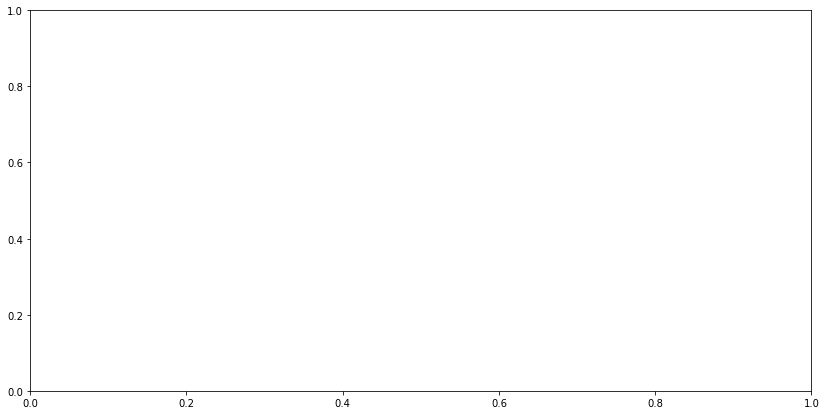

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Örneğin, haftalık duygu dağılımını görselleştirelim:
weekly_pd = weekly_sentiment.toPandas()

plt.figure(figsize=(14, 7))
sns.lineplot(data=weekly_pd, x="week", y="count", hue="sentiment")
plt.title('Haftalık Duygu Dağılımı')
plt.show()


In [50]:
from pyspark.sql.functions import when

# Duygu değerlerini numerik değerlere dönüştürelim
tweets_with_sentiment = tweets_with_sentiment.withColumn(
    "sentiment_value", 
    when(tweets_with_sentiment["sentiment"] == "positive", 1)
    .when(tweets_with_sentiment["sentiment"] == "negative", -1)
    .otherwise(0)
)

# Haftalık duygu ortalamaları
weekly_avg_sentiment = tweets_with_sentiment.groupBy("year", "week").avg("sentiment_value").orderBy("year", "week")
weekly_avg_sentiment.show()


+----+----+--------------------+
|year|week|avg(sentiment_value)|
+----+----+--------------------+
|2009|  15|  0.2477867543902085|
|2009|  16| 0.27623388618930966|
|2009|  17|  0.2729426096372496|
|2009|  18| 0.27601930852674517|
|2009|  19|  0.2905790725714472|
|2009|  20|  0.2772718571389504|
|2009|  21|  0.2953955712773013|
|2009|  22| 0.28736232845115905|
|2009|  23|   0.272955391852602|
|2009|  24| 0.25920930624631205|
|2009|  25| 0.10601231025227273|
|2009|  26|-0.01394444040433423|
+----+----+--------------------+



In [60]:
weekly_avg_sentiment_pd


,year,week,avg(sentiment_value),date
0,2009,15,0.247787,2009-04-13
1,2009,16,0.276234,2009-04-20
2,2009,17,0.272943,2009-04-27
3,2009,18,0.276019,2009-05-04
4,2009,19,0.290579,2009-05-11
5,2009,20,0.277272,2009-05-18
6,2009,21,0.295396,2009-05-25
7,2009,22,0.287362,2009-06-01
8,2009,23,0.272955,2009-06-08
9,2009,24,0.259209,2009-06-15


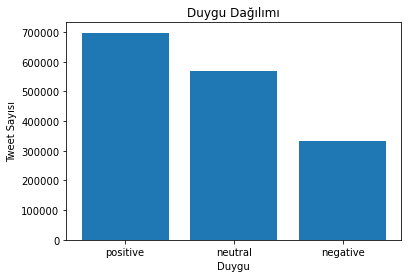

In [62]:
import matplotlib.pyplot as plt

sentiment_counts = tweets_with_sentiment.groupBy("sentiment").count().collect()
sentiments = [row["sentiment"] for row in sentiment_counts]
counts = [row["count"] for row in sentiment_counts]

plt.bar(sentiments, counts)
plt.title('Duygu Dağılımı')
plt.xlabel('Duygu')
plt.ylabel('Tweet Sayısı')
plt.show()


In [ ]:
from wordcloud import WordCloud

positive_tweets = tweets_with_sentiment.filter(tweets_with_sentiment.sentiment == "positive").rdd.flatMap(lambda x: x.text.split(" ")).collect()
negative_tweets = tweets_with_sentiment.filter(tweets_with_sentiment.sentiment == "negative").rdd.flatMap(lambda x: x.text.split(" ")).collect()

positive_wordcloud = WordCloud(background_color='white', width=600, height=400).generate(" ".join(positive_tweets))
negative_wordcloud = WordCloud(background_color='black', width=600, height=400).generate(" ".join(negative_tweets))

plt.figure(figsize=(10,5))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Olumlu Tweet Kelime Bulutu')
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Olumsuz Tweet Kelime Bulutu')
plt.show()


2023-08-13 13:51:23,900 WARN netty.NettyRpcEnv: Ignored failure: java.util.concurrent.TimeoutException: Cannot receive any reply from 10.0.2.15:40651 in 10000 milliseconds
